In [1]:
import cv2
import pickle
import helpers
import numpy as np
import matplotlib.pyplot as plt
from od_metrics.BoundingBox import BoundingBox
from od_metrics.BoundingBoxes import BoundingBoxes
from od_metrics.utils import BBFormat, BBType
from od_metrics.Evaluator import Evaluator

use_pickle = True
pickle_path = '../kaggle_dataset_863/kaggle_863_alt.pkl'

# Load Dataset

In [2]:
# load images and associated faces
# this takes a second since we load with cv2
if not use_pickle:
    imgs_with_labels = helpers.load_kaggle_863('../kaggle_dataset_863')
    imgs_with_labels = helpers.convert_kaggle_863_for_metrics(imgs_with_labels)
    with open(pickle_path, 'wb') as f:
        pickle.dump(imgs_with_labels, f)
else:
    with open(pickle_path, 'rb') as f:
        imgs_with_labels = pickle.load(f)

print(len(imgs_with_labels['raw_data']))

853


In [71]:
best_precs = []
best_recs = []
best_f = []

# Viola-Jones Analysis

In [4]:
haar_detection_results = {}
haar_cascade_names = [
    'frontalface_alt',
    'frontalface_alt2',
    'frontalface_alt_tree',
    'frontalface_default'
]
haar_cascade_paths = [cv2.data.haarcascades + 'haarcascade_' + n + '.xml'
                      for n in haar_cascade_names]
haar_results = {}
# clone ground bbox data to be populated by each haar detector
for name in haar_cascade_names:
    haar_detection_results[name] = imgs_with_labels['bboxes'].clone()

In [5]:
with open('haar_results.pkl', 'rb') as f:
    haar_detection_results = pickle.load(f)

In [6]:
evaluator = Evaluator()
metric_dict = {}
for t, result in haar_detection_results.items():
    metrics = evaluator.GetPascalVOCMetrics(haar_detection_results[t],
                                            IOUThreshold=0.3)
    total_pos = metrics[0]['total positives']
    tp = metrics[0]['total TP']
    fp = metrics[0]['total FP']
    metric_dict[t] = {
        'total positives': total_pos,
        'total TP': tp,
        'total FP': fp,
        'prec': helpers.compute_precision(tp, fp),
        'recall': helpers.compute_recall(tp, total_pos)
    }

In [7]:
metric_dict

{'frontalface_alt': {'total positives': 4072,
  'total TP': 772.0,
  'total FP': 90.0,
  'prec': 0.8955916473317865,
  'recall': 0.18958742632612965},
 'frontalface_alt2': {'total positives': 4072,
  'total TP': 851.0,
  'total FP': 148.0,
  'prec': 0.8518518518518519,
  'recall': 0.20898821218074656},
 'frontalface_alt_tree': {'total positives': 4072,
  'total TP': 117.0,
  'total FP': 1.0,
  'prec': 0.9915254237288136,
  'recall': 0.028732809430255402},
 'frontalface_default': {'total positives': 4072,
  'total TP': 750.0,
  'total FP': 417.0,
  'prec': 0.6426735218508998,
  'recall': 0.18418467583497053}}

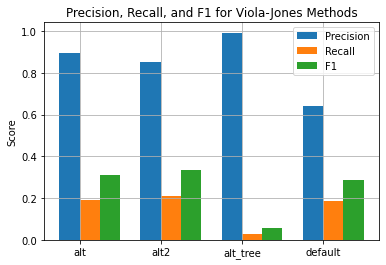

In [72]:
# plot
result_list = [metric_dict[n] for n in haar_cascade_names]
precisions = [res['prec'] for res in result_list]
recalls = [res['recall'] for res in result_list]
ind = np.arange(len(result_list))
short_names = [n[12:] for n in haar_cascade_names]
f_scores = []
for i in range(len(precisions)):
    p = precisions[i]
    r = recalls[i]
    f_scores.append(2*(p*r)/(p+r))

plt.bar(ind, precisions, 0.25, label='Precision')
plt.bar(ind+0.25, recalls, 0.25, label='Recall')
plt.bar(ind+0.5, f_scores, 0.25, label='F1')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1 for Viola-Jones Methods')
plt.xticks(ind + .25/2, tuple(short_names))
plt.legend(loc='best')
plt.grid()
plt.savefig('./figures/viola_jones.png', dpi=300, facecolor=plt.gcf().get_facecolor(), transparent=True)
plt.show()

In [73]:
best_precs.append(precisions[1])
best_recs.append(recalls[1])
best_f.append(f_scores[1])

# MTCNN Analysis

In [18]:
dl_detection_results = {}

In [19]:
with open('mtcnn_results.pkl', 'rb') as f:
    dl_detection_results['mtcnn'] = pickle.load(f)

In [20]:
evaluator = Evaluator()
mtcnn_metrics = evaluator.GetPascalVOCMetrics(dl_detection_results['mtcnn'],
                                              IOUThreshold=0.3)
total_pos = mtcnn_metrics[0]['total positives']
tp = mtcnn_metrics[0]['total TP']
fp = mtcnn_metrics[0]['total FP']
metric_dict_mtcnn = {
    'total positives': total_pos,
    'total TP': tp,
    'total FP': fp,
    'prec': helpers.compute_precision(tp, fp),
    'recall': helpers.compute_recall(tp, total_pos)
}

In [21]:
metric_dict_mtcnn

{'total positives': 4072,
 'total TP': 2466.0,
 'total FP': 155.0,
 'prec': 0.9408622663105685,
 'recall': 0.6055992141453831}

In [22]:
with open('mtcnn_fdet_results.pkl', 'rb') as f:
    dl_detection_results['fdet_mtcnn'] = pickle.load(f)

In [23]:
evaluator = Evaluator()
mtcnn_fdet_metrics = evaluator.GetPascalVOCMetrics(dl_detection_results['fdet_mtcnn'],
                                            IOUThreshold=0.3)
total_pos = mtcnn_fdet_metrics[0]['total positives']
tp = mtcnn_fdet_metrics[0]['total TP']
fp = mtcnn_fdet_metrics[0]['total FP']
metric_dict_mtcnn_fdet = {
    'total positives': total_pos,
    'total TP': tp,
    'total FP': fp,
    'prec': helpers.compute_precision(tp, fp),
    'recall': helpers.compute_recall(tp, total_pos)
}

In [24]:
metric_dict_mtcnn_fdet

{'total positives': 4072,
 'total TP': 2563.0,
 'total FP': 234.0,
 'prec': 0.9163389345727565,
 'recall': 0.6294204322200393}

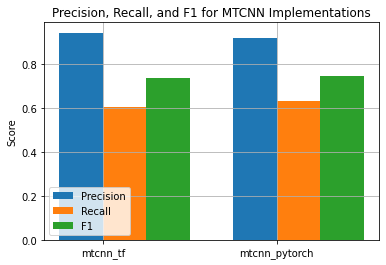

In [74]:
# plot
precisions = [metric_dict_mtcnn['prec'], metric_dict_mtcnn_fdet['prec']]
recalls = [metric_dict_mtcnn['recall'], metric_dict_mtcnn_fdet['recall']]
ind = np.arange(2)
names = ('mtcnn_tf', 'mtcnn_pytorch')
f_scores = []
for i in range(len(precisions)):
    p = precisions[i]
    r = recalls[i]
    f_scores.append(2*(p*r)/(p+r))

plt.bar(ind, precisions, 0.25, label='Precision')
plt.bar(ind+0.25, recalls, 0.25, label='Recall')
plt.bar(ind+0.5, f_scores, 0.25, label='F1')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1 for MTCNN Implementations')
plt.xticks(ind + .25/2, tuple(names))
plt.legend(loc='lower left')
plt.grid()
plt.savefig('./figures/mtcnn.png', dpi=300, transparent=True)
plt.show()

In [76]:
best_precs.append(precisions[1])
best_recs.append(recalls[1])
best_f.append(f_scores[1])

# RetinaFace Analysis

## MobileNet

In [77]:
thresholds = [70, 75, 80, 85, 90, 95]
retina_face_data = {}
retina_face_eval = {}

for t in thresholds:
    with open(f'retinaface_mobilenet_results_{t}.pkl', 'rb') as f:
        retina_face_data[t] = pickle.load(f)
    evaluator = Evaluator()
    retinaface_mobilenet_alt_metrics = evaluator.GetPascalVOCMetrics(retina_face_data[t],
                                                IOUThreshold=0.3)
    total_pos = retinaface_mobilenet_alt_metrics[0]['total positives']
    tp = retinaface_mobilenet_alt_metrics[0]['total TP']
    fp = retinaface_mobilenet_alt_metrics[0]['total FP']
    metric_dict_retinaface_mobilenet_alt = {
        'total positives': total_pos,
        'total TP': tp,
        'total FP': fp,
        'prec': helpers.compute_precision(tp, fp),
        'recall': helpers.compute_recall(tp, total_pos)
    }
    retina_face_eval[t] = metric_dict_retinaface_mobilenet_alt

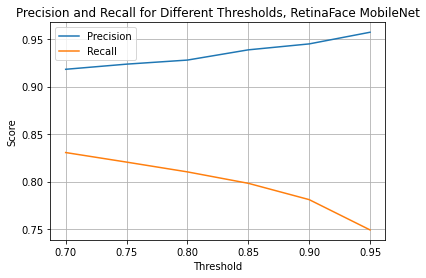

In [78]:
# plot
result_list = [retina_face_eval[t] for t in thresholds]
precisions = [res['prec'] for res in result_list]
recalls = [res['recall'] for res in result_list]
ind = np.arange(len(result_list))
names = [.70, .75, .80, .85, .90, .95]

plt.plot(names, precisions, label='Precision')
plt.plot(names, recalls, label='Recall')

plt.ylabel('Score')
plt.xlabel('Threshold')
plt.title('Precision and Recall for Different Thresholds, RetinaFace MobileNet')
# plt.xticks(ind + .25/2, tuple(short_names))
plt.legend(loc='best')
plt.grid()
plt.savefig('./figures/retinaface_mobilenet_thresh.png', dpi=300, transparent=True)
plt.show()

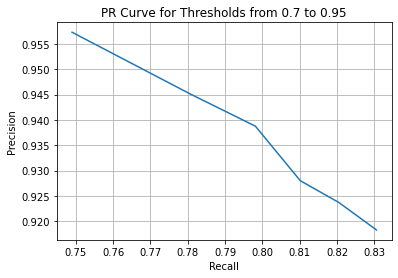

In [79]:
plt.plot(recalls, precisions)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("PR Curve for Thresholds from 0.7 to 0.95")
plt.grid()
plt.savefig('./figures/retinaface_mobilenet_pr.png', dpi=300, transparent=True)
plt.show()

In [80]:
retina_face_eval

{70: {'total positives': 4072,
  'total TP': 3382.0,
  'total FP': 301.0,
  'prec': 0.9182731468911214,
  'recall': 0.8305500982318271},
 75: {'total positives': 4072,
  'total TP': 3341.0,
  'total FP': 276.0,
  'prec': 0.923693668786287,
  'recall': 0.8204813359528488},
 80: {'total positives': 4072,
  'total TP': 3299.0,
  'total FP': 256.0,
  'prec': 0.9279887482419128,
  'recall': 0.8101669941060904},
 85: {'total positives': 4072,
  'total TP': 3250.0,
  'total FP': 212.0,
  'prec': 0.9387637203928365,
  'recall': 0.7981335952848723},
 90: {'total positives': 4072,
  'total TP': 3180.0,
  'total FP': 185.0,
  'prec': 0.9450222882615156,
  'recall': 0.7809430255402751},
 95: {'total positives': 4072,
  'total TP': 3050.0,
  'total FP': 136.0,
  'prec': 0.9573132454488387,
  'recall': 0.7490176817288802}}

In [81]:
best_mobile_net = retina_face_eval[70]
# best bc it has highest recall rate
retina_face_compare = {}
retina_face_compare['mobilenet'] = best_mobile_net

In [83]:
with open('retinaface_resnet50_alt.pkl', 'rb') as f:
    retinaface_resnet_res = pickle.load(f)

evaluator = Evaluator()
retinaface_resnet50_alt_metrics = evaluator.GetPascalVOCMetrics(retinaface_resnet_res,
                                            IOUThreshold=0.3)
total_pos = retinaface_resnet50_alt_metrics[0]['total positives']
tp = retinaface_resnet50_alt_metrics[0]['total TP']
fp = retinaface_resnet50_alt_metrics[0]['total FP']
metric_dict_retinaface_resnet50_alt = {
    'total positives': total_pos,
    'total TP': tp,
    'total FP': fp,
    'prec': helpers.compute_precision(tp, fp),
    'recall': helpers.compute_recall(tp, total_pos)
}

retina_face_compare['resnet'] = metric_dict_retinaface_resnet50_alt

In [84]:
retina_face_compare

{'mobilenet': {'total positives': 4072,
  'total TP': 3382.0,
  'total FP': 301.0,
  'prec': 0.9182731468911214,
  'recall': 0.8305500982318271},
 'resnet': {'total positives': 4072,
  'total TP': 3674.0,
  'total FP': 619.0,
  'prec': 0.8558117866293967,
  'recall': 0.9022593320235757}}

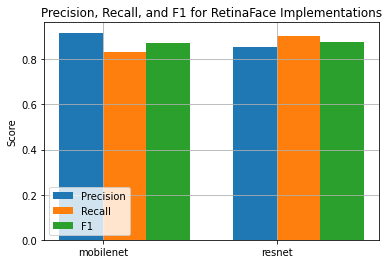

In [85]:
# plot
result_list = [retina_face_compare[n] for n in retina_face_compare.keys()]
precisions = [res['prec'] for res in result_list]
recalls = [res['recall'] for res in result_list]
ind = np.arange(len(result_list))
names = list(retina_face_compare.keys())
f_scores = []
for i in range(len(precisions)):
    p = precisions[i]
    r = recalls[i]
    f_scores.append(2*(p*r)/(p+r))

plt.bar(ind, precisions, 0.25, label='Precision')
plt.bar(ind+0.25, recalls, 0.25, label='Recall')
plt.bar(ind+0.5, f_scores, 0.25, label='F1')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1 for RetinaFace Implementations')
plt.xticks(ind + .25/2, tuple(names))
plt.legend(loc='lower left')
plt.grid()
plt.savefig('./figures/retinaface.png', dpi=300, transparent=True)
plt.show()

In [86]:
best_precs.append(precisions[0])
best_recs.append(recalls[0])
best_f.append(f_scores[0])

## Final Graph

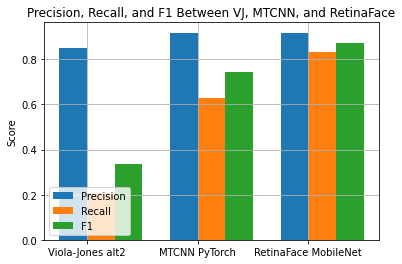

In [87]:
# plot
ind = np.arange(len(best_f))
names = ('Viola-Jones alt2', 'MTCNN PyTorch', 'RetinaFace MobileNet')

plt.bar(ind, best_precs, 0.25, label='Precision')
plt.bar(ind+0.25, best_recs, 0.25, label='Recall')
plt.bar(ind+0.5, best_f, 0.25, label='F1')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Between VJ, MTCNN, and RetinaFace')
plt.xticks(ind + .25/2, names)
plt.legend(loc='lower left')
plt.grid()
plt.savefig('./figures/full_compare.png', dpi=300, transparent=True)
plt.show()

# Classifier Dataset

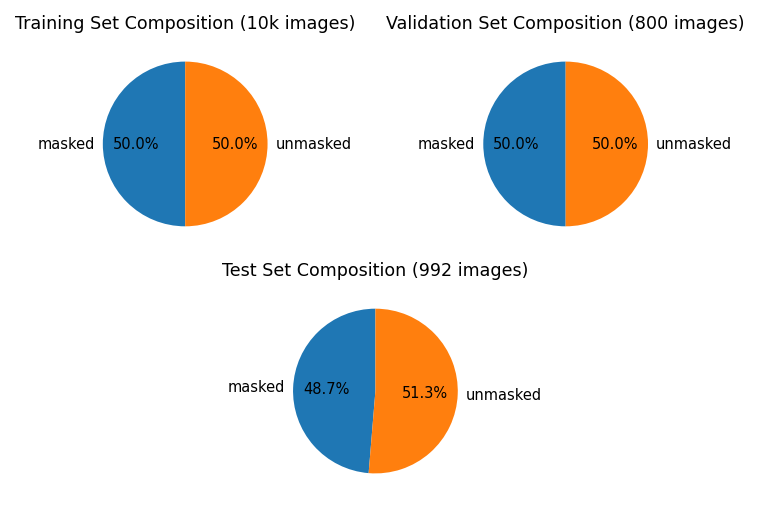

In [106]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 7.0

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace = 0.5)

ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

train = [5000, 5000]
validate = [400, 400]
test = [483, 509]

labels = ['masked', 'unmasked']

# plt.subplot(2, 2, 1)
# plt.title('Test')
# plt.pie(train, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.pie(train, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Training Set Composition (10k images)')

# plt.subplot(2, 2, 2)
# plt.pie(validate, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.pie(validate, labels=labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Validation Set Composition (800 images)')

# plt.subplot(2, 2, 3)
# plt.pie(test, labels=labels, autopct='%1.1f%%', startangle=90)
ax3.pie(test, labels=labels, autopct='%1.1f%%', startangle=90)
ax3.set_title('Test Set Composition (992 images)')

plt.gcf().set_dpi(150)
plt.savefig('./figures/classifier_dataset.png', dpi=300, transparent=True)